<a href="https://colab.research.google.com/github/Wayan123/crossformer/blob/main/inference_pretrained_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Minimal CrossFormer Inference Example

This Colab demonstrates how to load a pre-trained / finetuned CrossFormer checkpoint, run inference for a single-arm and bimanual manipulation system, and compare the outputs to the true actions.

First, let's start with a minimal example!

In [1]:
# run this block if you're using Colab

# Download repo
!git clone https://github.com/rail-berkeley/crossformer.git
%cd crossformer
# Install repo
!pip3 install -e .
!pip3 install -r requirements.txt
!pip3 install --upgrade "jax[cuda11_pip]==0.4.20" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

fatal: destination path 'crossformer' already exists and is not an empty directory.
/content/crossformer
Obtaining file:///content/crossformer
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for crossformer (pyproject.toml) ... done
  Created wheel for crossformer: filename=crossformer-0.0.0-0.editable-py3-none-any.whl size=3521 sha256=f9ba3cd6a2c86ec4eff6a80ebde9c1f8c9da0b37c2590e885893b99b6af1f308
  Stored in directory: /tmp/pip-ephem-wheel-cache-e6st97bf/wheels/f8/25/90/99735683328193ee1a06ce6124dc0649353724894e7a803f5e
Successfully built crossformer
  Attempting uninstall: crossformer
    Found existing installation: crossformer 0.0.0
    Uninstalling crossformer-0.0.0:
      Successfully uninstalled crossformer-0.0.0
  Using cached dlimp-0.0.1-py3-none-any.whl
Looking in links: https://storage.googleapis

In [2]:
from crossformer.model.crossformer_model import CrossFormerModel

model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/608 [00:00<?, ?B/s]

dataset_statistics.json:   0%|          | 0.00/86.2k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/64.4k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/519M [00:00<?, ?B/s]

example_batch.msgpack:   0%|          | 0.00/4.56M [00:00<?, ?B/s]

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.11/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


In [3]:
# We'll demonstrate how to create an observation and task dictionary for a bimanual task.
# Then we'll use them to sample an action from the model.

import jax
import numpy as np

# create a random image
img = np.random.randint(0, 255, size=(224, 224, 3))
# add batch and observation history dimension (CrossFormer accepts a history of up to 5 time-steps)
img = img[None, None]
# our bimanual training data has an overhead view and two wrist views
observation = {
    "image_high": img,
    "image_left_wrist": img,
    "image_right_wrist": img,
    "timestep_pad_mask": np.array([[True]]),
}
# create a task dictionary for a language task
task = model.create_tasks(texts=["uncap the pen"])
# we need to specify the bimanual head here
action = model.sample_actions(observation, task, head_name="bimanual", rng=jax.random.PRNGKey(0))
print(action)  # [batch, action_chunk, action_dim]

[[[-0.30072156 -0.8090332   0.96496534 ... -0.05825038 -0.29595166
    0.4762882 ]
  [-0.32095602 -0.82409054  0.96961504 ... -0.03216244 -0.29076365
    0.48043507]
  [-0.3394402  -0.8385326   0.97229284 ... -0.00743542 -0.28522143
    0.48486882]
  ...
  [ 0.74716055  0.5729156  -0.37378255 ...  0.7107658  -0.15497527
    0.4799072 ]
  [ 0.77611125  0.5646752  -0.32498974 ...  0.6893814  -0.1470506
    0.48114312]
  [ 0.8055543   0.5525097  -0.27187917 ...  0.6639102  -0.13927269
    0.48155338]]]


# Step 2: Run Inference on Full Trajectories

That was easy! Now let's try to run inference across a whole single-arm trajectory and visualize the results!

In [4]:
# Install mediapy for visualization
!pip install mediapy
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.3 MB/s eta 0:00:00


In [5]:
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

## Load Model Checkpoint
First, we will load the pre-trained checkpoint using the `load_pretrained()` function. You can specify the path to a checkpoint directory or a HuggingFace path.

Below, we are loading directly from HuggingFace.


In [6]:
from crossformer.model.crossformer_model import CrossFormerModel

model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

## Load Data
Next, we will load a trajectory from the Bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [7]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(
    builder_dir="gs://gresearch/robotics/bridge/0.1.0/"
)
ds = builder.as_dataset(split="train[:1]")

# sample episode and resize to 224x224 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode["steps"])
images = [
    cv2.resize(np.array(step["observation"]["image"]), (224, 224)) for step in steps
]

# extract goal image and language instruction
goal_image = images[-1]
language_instruction = (
    steps[0]["observation"]["natural_language_instruction"].numpy().decode()
)

# visualize episode
print(f"Instruction: {language_instruction}")
mediapy.show_video(images, fps=10)

Instruction: Place the can to the left of the pot.


## Run Inference

Next, we will run inference over the images in the episode using the loaded model.
Below we demonstrate setups for both goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [8]:
WINDOW_SIZE = 5

# create task dictionary
task = model.create_tasks(
    goals={"image_primary": goal_image[None]}
)  # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])  # for language conditioned

In [9]:
# run inference loop, the model only uses 3rd person image observations for bridge

# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step : step + WINDOW_SIZE])[None]
    observation = {
        "image_primary": input_images,
        "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
    }

    # we need to pass in the dataset statistics to unnormalize the actions
    actions = model.sample_actions(
        observation,
        task,
        head_name="single_arm",
        unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"],
        rng=jax.random.PRNGKey(0),
    )
    actions = actions[0]  # remove batch

    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(
        np.concatenate(
            (
                steps[final_window_step]["action"]["world_vector"],
                steps[final_window_step]["action"]["rotation_delta"],
                np.array(steps[final_window_step]["action"]["open_gripper"]).astype(
                    np.float32
                )[None],
            ),
            axis=-1,
        )
    )

100%|██████████| 34/34 [01:46<00:00,  3.14s/it]


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

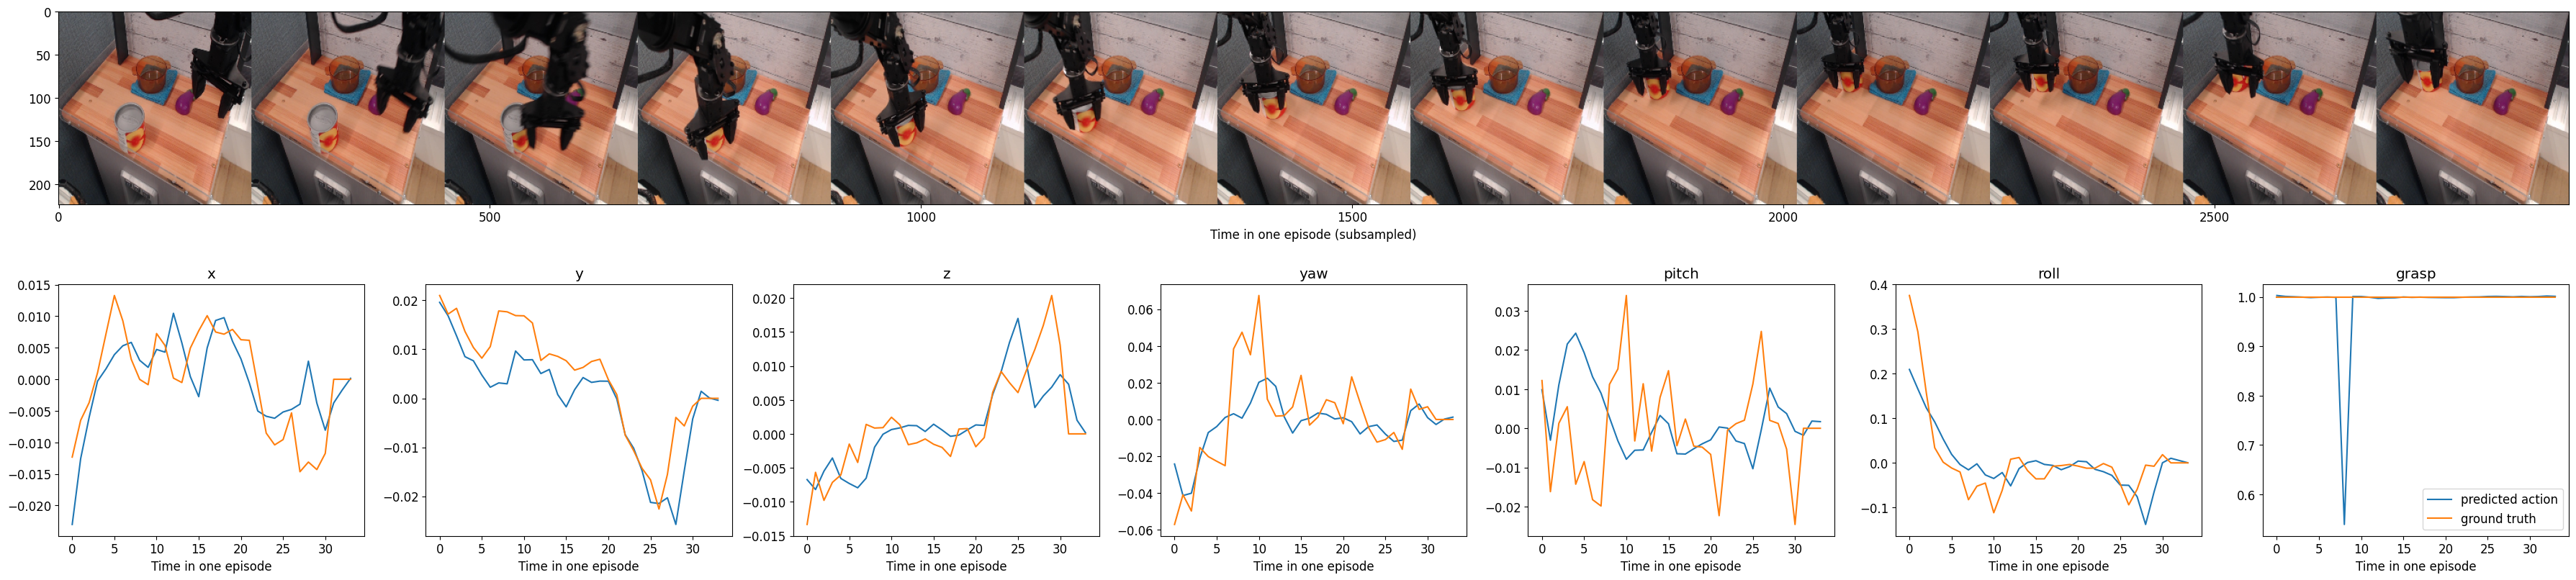

In [10]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()